In [118]:
import shap
import numpy as np
import pandas as pd
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
from seaborn import kdeplot
from pickle import dump, load
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon
import warnings; warnings.simplefilter('ignore')
%matplotlib notebook

In [119]:
loc = EarthLocation.of_site('greenwich') 

def to_numpy(c):
    return np.array([c.x/u.km, c.y/u.km, c.z/u.km])

Cartesian orbit of mercury


<IPython.core.display.Javascript object>


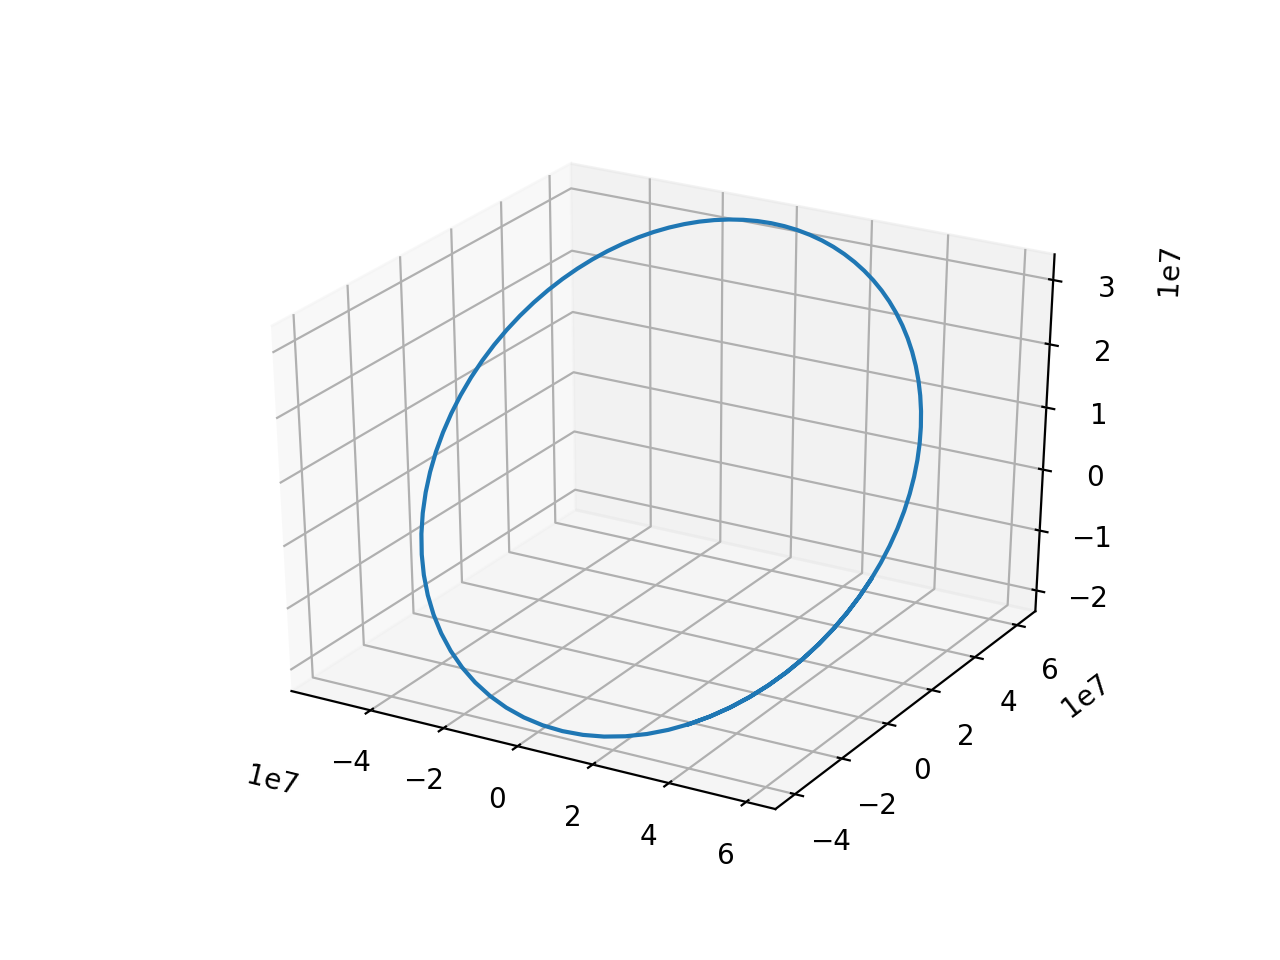

Cartesian orbit of venus


<IPython.core.display.Javascript object>


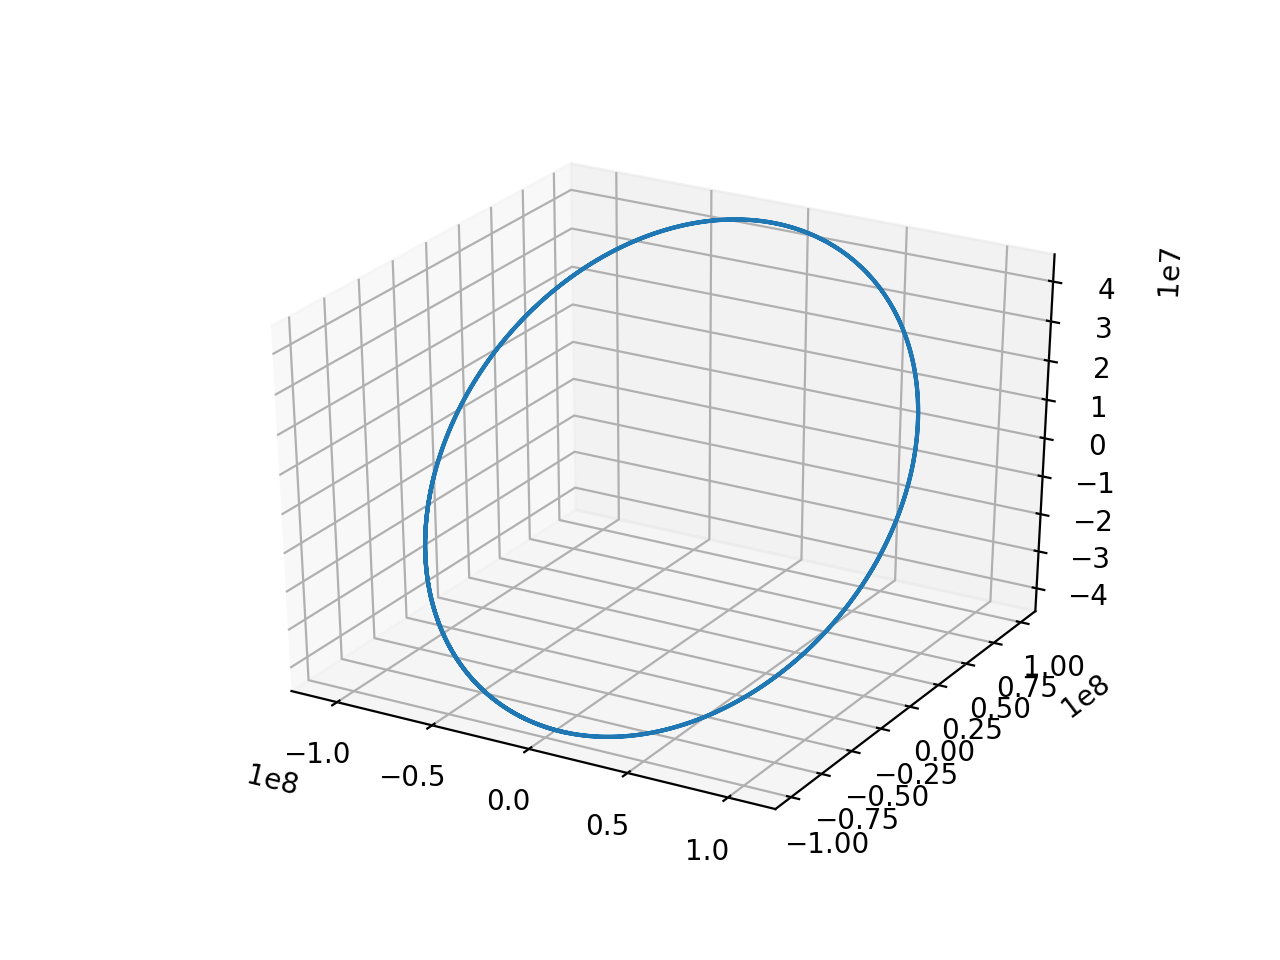

Cartesian orbit of earth


<IPython.core.display.Javascript object>


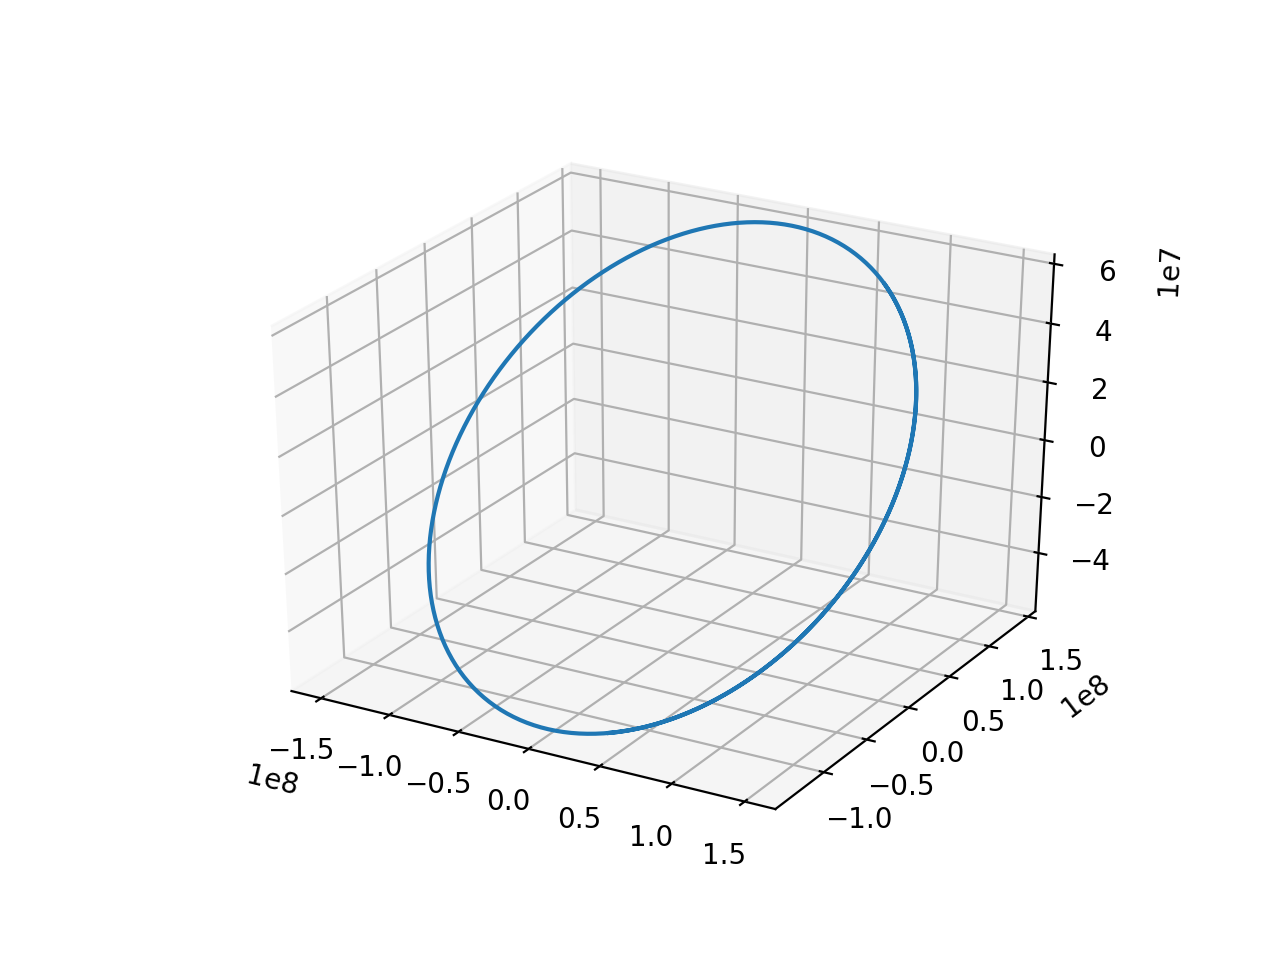

Cartesian orbit of mars


<IPython.core.display.Javascript object>


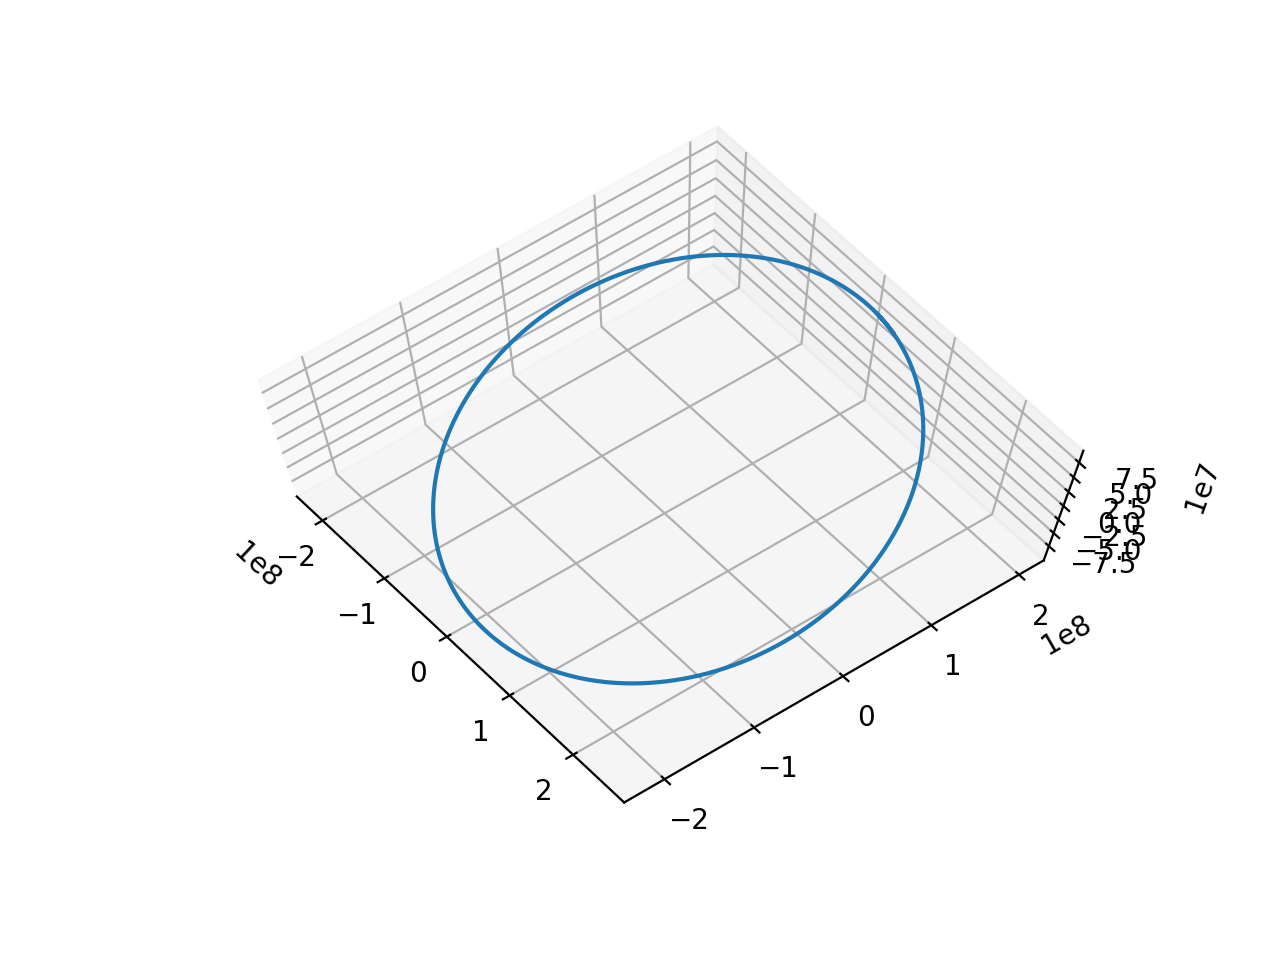

In [122]:
#Split the dataframe by planets and add a second difference column

planets = ['mercury', 'venus', 'earth', 'mars']
days = {
    'mercury':100,
    'venus':500,
    'earth':500,
    'mars':700
}
step = {
    'mercury':1,
    'venus':1,
    'earth':1,
    'mars':1
}

START_TIME = 2287185


X = dict()
y = dict()

LOAD = False
if LOAD:
    X = load(open("X.bin" , "rb"))
    y = load(open("y.bin" , "rb"))

else:
    for planet in planets:
#         dfp = df[df["Body"] == planet][["RA", "Dec", "Dist", "Dist_Sun"]]
#         dfs = df[df["Body"] == "Sun"][["RA", "Dec", "Dist", "Dist_Sun"]]
#         dfp.reset_index(inplace = True, drop = True)
#         dfs.reset_index(inplace = True, drop = True)
#         pcoords = dfp[["RA", "Dec", "Dist"]].to_numpy()
#         scoords = dfs[["RA", "Dec", "Dist"]].to_numpy()
        
#         coords = np.array([
#             to_numpy(SkyCoord(ra=pcoords[i][0]*u.degree, dec=pcoords[i][1]*u.degree, distance=pcoords[i][2]))
#             -to_numpy(SkyCoord(ra=scoords[i][0]*u.degree, dec=scoords[i][1]*u.degree, distance=scoords[i][2])) 
#             for i in range(len(pcoords))])
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         ax.plot3D(coords[:,0], coords[:,1], coords[:,2])
#         #plt.scatter(pcoords[:35,0], pcoords[:35,1])
#         ds_diff2 = np.linalg.norm(coords[2:] - 2*coords[1:-1] + coords[:-2], axis=1)
#         #dfp["Dist_Sun"] = 1/dfp["Dist_Sun"]**2 #include inverse square feature
#         X[planet] = dfp[:-2].reset_index(drop=True)
#         y[planet] = pd.DataFrame({"Second Difference":ds_diff2})
        t = Time([i + START_TIME for i in range(0,days[planet],step[planet])], format='jd')
        with solar_system_ephemeris.set('jpl'):
            plnt = get_body(planet, t, loc)
            sun = get_body('sun', t, loc)
        r = sun.cartesian-plnt.cartesian
        rcoords = np.array([to_numpy(r[i]) for i in range(len(r))])
        print("Cartesian orbit of "+planet)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot3D(rcoords[:,0], rcoords[:,1], rcoords[:,2])
        
        X[planet] = pd.DataFrame({
            "RA": plnt.ra,
            "Dec": plnt.dec,
            
        })
        y[planet] = pd.DataFrame({"Second Difference":np.linalg.norm(rcoords[2:] - 2*rcoords[1:-1] + rcoords[:-2], axis=1)})
        
        
            

dump(X, open("X.bin", "wb"))
dump(y, open("y.bin", "wb"))

In [73]:
#Run randomized hyperparameter search for each of the training targets

LOAD = True

if LOAD:
    params = load(open("params.bin" , "rb"))
    
else:
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    params = dict()
    for planet in planets:
        rf = RandomForestRegressor()
        rf_random = RandomizedSearchCV(estimator = rf, 
                                       param_distributions = random_grid, 
                                       n_iter = 100, cv = 3, 
                                       verbose=2, 
                                       random_state=1, 
                                       n_jobs = -1)
        rf_random.fit(X[planet],y[planet])
        params[planet] = rf_random.best_params_
        print("Best parameters for "+planet+":")
        pprint(params[planet])
        print()

dump(params, open("params.bin", "wb")) #pickle best parameters

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Error for Mars:
Bias: -0.005307035250363951
Variance: 0.012694949545617673
SSE 0.01272311416876628



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


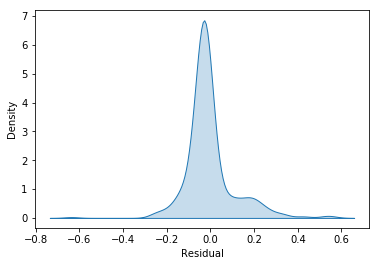

In [74]:
#Evaluate model performance on a validation dataset

residuals = dict()
rfs = dict()

ax = None

for planet in planets:
    pparams = params[planet]
    rf = RandomForestRegressor(n_estimators=pparams["n_estimators"], 
                                            min_samples_split = pparams["min_samples_split"], 
                                            min_samples_leaf = pparams["min_samples_leaf"], 
                                            max_features = pparams["max_features"], 
                                            max_depth = pparams["max_depth"], 
                                            bootstrap = pparams["bootstrap"])
    X_train, X_test, y_train, y_test = train_test_split(X[planet], y[planet]) 
    rf.fit(X_train, y_train)
    
    res = y_test.to_numpy().ravel() - rf.predict(X_test)
    
    print("Error for "+planet+":")
    bias = np.mean(res)
    variance = np.var(res)
    error = bias**2 + variance
    print("Bias: "+str(bias))
    print("Variance: "+str(variance))
    print("SSE "+str(error))
    print()
    residuals[planet] = res
    ax = kdeplot(
        data=pd.DataFrame(residuals)[planet], shade=True)
    ax.set(xlabel='Residual', ylabel='Density')
    
    rf.fit(X[planet], y[planet])
    rfs[planet] = rf

ax.get_figure().savefig("kde.png")
    
dump(residuals, open("residuals.bin", "wb")) #pickle residuals
dump(rfs, open("residuals.bin", "wb")) #pickle random forests

In [75]:
#Compute SHAP values for each planet

shap_values = dict()
SHAP_N = 1000
Xshap = {planet:X[planet].sample(n=SHAP_N) for planet in planets}

LOAD = False

if LOAD:
    shap_values = load(open("shap_values.bin", "rb"))
    Xshap = load(open("Xshap.bin", "rb"))

for planet in planets:
    if not LOAD:
        explainer = shap.TreeExplainer(rfs[planet])
        shap_values[planet] = explainer.shap_values(Xshap[planet])
    shap.summary_plot(shap_values[planet], Xshap[planet], show=False)
    plt.savefig("Summary_Plot_"+planet+".png",bbox_inches='tight')
    plt.clf()

dump(shap_values, open("shap_values.bin", "wb"))
dump(Xshap, open("Xshap.bin", "wb"))

<Figure size 576x223.2 with 0 Axes>

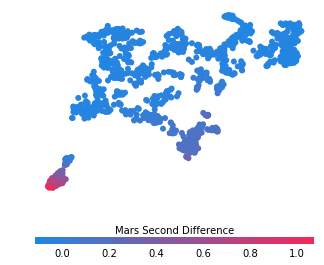

In [76]:
#TSNE Visualization of the SHAP values

cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

for planet in planets:
    shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[planet])
    f = plt.figure(figsize=(5,5))
    plt.scatter(shap_embedded[:,0],
               shap_embedded[:,1],
               c=shap_values[planet][:1000,:].sum(1).astype(np.float64),
               linewidth=0, alpha=1., cmap=red_blue_solid)
    cb = plt.colorbar(label=planet+" Second Difference", aspect=40, orientation="horizontal")
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    plt.gca().axis("off")
    plt.savefig("TSNE_"+planet+".png",bbox_inches='tight')

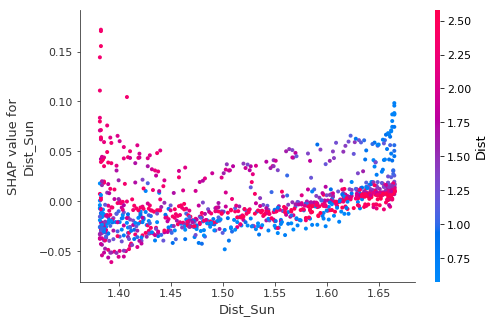

In [77]:
# Dependence Plots

#SHAP dependence on Dist_Sun
X_dist_sun = dict()
y_sv = dict()

LOAD = False

if LOAD:
    X_dist_sun = load(open("Xdep.bin", "rb"))
    y_sv = load(open("ydep.bin", "rb"))

for planet in planets:
    if not LOAD:
        idx = np.where(Xshap[planet].columns=="Dist_Sun")[0][0]
        X_dist_sun[planet] = Xshap[planet].iloc[:,idx]
        y_sv[planet] = shap_values[planet][:,idx]
    fig = shap.dependence_plot("Dist_Sun", shap_values[planet], Xshap[planet], show=False)
    plt.savefig("Dependence_Plot_"+planet+".png",bbox_inches='tight')

dump(X_dist_sun, open("Xdep.bin", "wb"))
dump(y_sv, open("ydep.bin", "wb"))
    

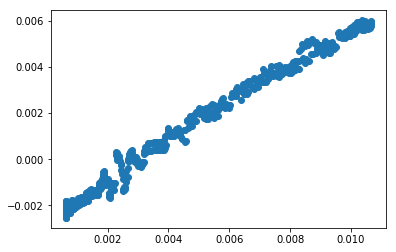

In [50]:
plt.plot(X_dist_sun["Pallas"]**(6/2), y_sv["Pallas"], "o")

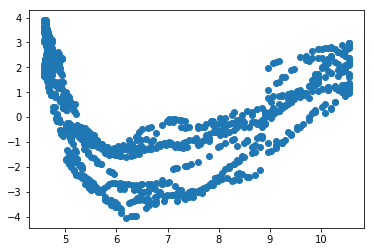

In [37]:
plt.plot(X_dist_sun["Mercury"], y_sv["Mercury"], "o")